In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from model_builder import arima_model
from matplotlib import pyplot as plt

from model_builder import stationarity_test
from criteria_housing import name_zipcode_area
from model_builder import dataframe_cleaner
%load_ext autoreload
%autoreload 2

In [2]:
#loading all zipcodes pandas dataframes
zillow_df = pd.read_csv('../write_data/zipcodes_all_price.csv',
                        index_col = 0, parse_dates = True)
zillow_df.columns = pd.to_numeric(zillow_df.columns)

# loading top 100 ROI zipcodes pandas dataframes
top_df = pd.read_csv('../write_data/top_monthly.csv', 
                     index_col = 0, parse_dates = True)
top_df.columns = pd.to_numeric(top_df.columns)

# loading bottom 100 ROI zipcodes pandas dataframes
bottom_df = pd.read_csv('../write_data/bottom_monthly.csv', 
                        index_col = 0, parse_dates = True)
bottom_df.columns = pd.to_numeric(bottom_df.columns)

# loading random 100 ROI zipcodes pandas dataframes
random_df = pd.read_csv('../write_data/random_monthly.csv', 
                        index_col = 0, parse_dates = True)
random_df.columns = pd.to_numeric(random_df.columns)

In [3]:
bottom_df.head()

,33415,47838,24330,92225,49331,34972,44688,58047,97148,48159,...,11205,60612,45121,16637,94957,71238,10128,11222,16625,70090
Date_index,,,,,,,,,,,,,,,,,,,,,
1996-04-01,70000.0,NaN,32200.0,75300.0,98000.0,43500.0,50000.0,NaN,109700.0,76000.0,...,NaN,100900.0,61600.0,NaN,755900.0,NaN,3676700.0,149200.0,NaN,NaN
1996-05-01,70100.0,NaN,32300.0,75400.0,99700.0,43600.0,50500.0,NaN,110300.0,76000.0,...,NaN,101400.0,61400.0,NaN,754600.0,NaN,3704200.0,148400.0,NaN,NaN
1996-06-01,70300.0,NaN,32500.0,75500.0,101400.0,43800.0,51000.0,NaN,111000.0,76000.0,...,NaN,101900.0,61200.0,NaN,753300.0,NaN,3729600.0,147500.0,NaN,NaN
1996-07-01,70400.0,NaN,32600.0,75600.0,102800.0,43900.0,51400.0,NaN,111700.0,76000.0,...,NaN,102300.0,61000.0,NaN,752000.0,NaN,3754600.0,146600.0,NaN,NaN
1996-08-01,70600.0,NaN,32800.0,75700.0,104100.0,43900.0,51900.0,NaN,112200.0,76000.0,...,NaN,102700.0,60900.0,NaN,751000.0,NaN,3781800.0,146000.0,NaN,NaN


In [13]:
#filtering out dataframes with null values
print('old top_df containing null columns:', 
      len([col for col in top_df if top_df[col].isnull().sum()>0]))
top_df = dataframe_cleaner(top_df)

print('cleaned top_df containing null columns:', 
      len([col for col in top_df if top_df[col].isnull().sum()>0]) )

old top_df containing null columns: 0
cleaned top_df containing null columns: 0


In [5]:
#filtering out random and bottom dataframes with null values
bottom_df = dataframe_cleaner(bottom_df)
random_df = dataframe_cleaner(random_df)

In [7]:
#loading state, county and region details for our data
region_df = pd.read_csv('../write_data/regions_zipcode.csv', index_col=0)

region_df.head()

,RegionID,RegionName,City,State,Metro,CountyName
0,84654,60657,Chicago,IL,Chicago,Cook
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin
2,91982,77494,Katy,TX,Houston,Harris
3,84616,60614,Chicago,IL,Chicago,Cook
4,93144,79936,El Paso,TX,El Paso,El Paso


* **Checking for stationarity of data before building models**

* **Finding autoregressive order p using autocorrelation**

In [8]:
top_df.head()

,7106,29661,64110,20621,7103,18346,60954,34785,18224,17931,...,8270,18651,65723,14572,7002,14809,18355,12528,28786,14062
Date_index,,,,,,,,,,,,,,,,,,,,,
1996-04-01,91400.0,56500.0,59200.0,94300.0,78000.0,53600.0,78400.0,46400.0,41100.0,36700.0,...,93100.0,45400.0,29900.0,52200.0,145000.0,45900.0,60900.0,107600.0,48900.0,62800.0
1996-05-01,91300.0,56800.0,59500.0,95200.0,78100.0,53800.0,78300.0,46300.0,40900.0,36800.0,...,93300.0,45300.0,30300.0,52300.0,144500.0,45900.0,61000.0,107400.0,48900.0,62600.0
1996-06-01,91200.0,57200.0,59700.0,96000.0,78200.0,53900.0,78000.0,46200.0,40600.0,36800.0,...,93500.0,45200.0,30600.0,52400.0,143900.0,45800.0,61000.0,107300.0,48800.0,62500.0
1996-07-01,91200.0,57600.0,59900.0,96900.0,78300.0,54100.0,77900.0,46100.0,40400.0,36800.0,...,93600.0,45100.0,30900.0,52500.0,143300.0,45700.0,61100.0,107100.0,48500.0,62300.0
1996-08-01,91200.0,58000.0,60200.0,97700.0,78300.0,54200.0,77800.0,46000.0,40200.0,36800.0,...,93800.0,45000.0,31300.0,52500.0,142800.0,45700.0,61100.0,107000.0,48200.0,62100.0


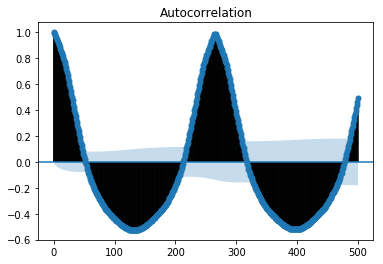

In [10]:
# ACF, 
plot_acf(top_df[7106], lags=500, alpha=0.05)
plt.show()

* **This sequence is repeating every twenty years**

In [11]:
#auto correlation function. A value greater than 0.05 is a viable AR order p
acf(top_df[7106], nlags=50)[:5]

array([1.        , 0.99324043, 0.98441982, 0.9742717 , 0.96320004])

* **Finding moving average order q using partial autocorrelation**

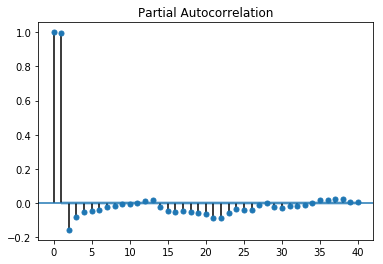

In [12]:
#partial autocorrelation function. A value greater than 0.05 is a viable MA order q
plot_pacf(top_df[7106], lags=40, alpha=0.05);

* **since the diff() made the data stationary, the integrated d is 1.**

In [460]:
#picking top zipcodes
model_topzipcodes = top_df.columns[:6]
model_topzipcodes

Int64Index([7106, 29661, 64110, 20621, 7103, 18346], dtype='int64')

In [462]:
model_bottomzipcodes = bottom_df.columns[:6]
model_bottomzipcodes

Int64Index([33415, 24330, 92225, 49331, 34972, 44688], dtype='int64')

In [448]:
model_95008 = arima_model(zillow_df[95008])

//anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
//anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [476]:
model_33415 = arima_model(zillow_df[33415])

In [468]:
import seaborn as sns

//anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


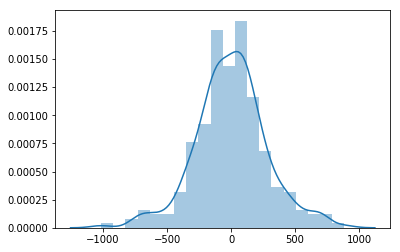

In [472]:
sns.distplot(mode_33415.resid);
# sns.distplot(model_95008.resid)

In [474]:
forcast_santa = model_95008.predict(1, 300, typ='levels')

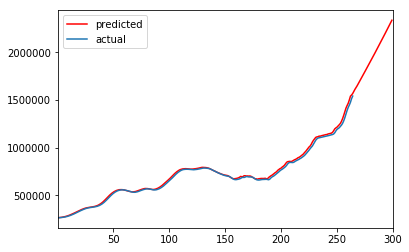

In [475]:
plt.plot(santa_dollars[0] + np.cumsum(forcast_santa), color = 'red', label='predicted')
plt.plot(zillow_df[95008].values, label = 'actual')
plt.legend()
plt.xlim(1,300)
plt.show()

In [ ]:
stationarity_test(zillow_df[95008], ) 

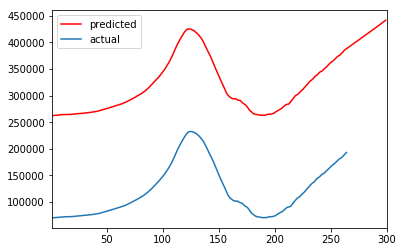

In [478]:
forcast_33415 = model_33415.predict(1, 300, typ='levels')
plt.plot(santa_dollars[0] + np.cumsum(forcast_33415), color = 'red', label='predicted')
plt.plot(zillow_df[33415].values, label = 'actual')
plt.legend()
plt.xlim(1,300)
plt.show()

In [481]:
(santa_dollars[0] + np.cumsum(forcast_33415))[275]

404666.94017891696